In [67]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [3]:
newsgroups_all = fetch_20newsgroups(subset = 'all', shuffle = True, remove = ('headers', 'footers', 'quotes'))

In [4]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newsgroups_all.data)

In [5]:
y = newsgroups_all.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [31]:
rfc = RandomForestClassifier()
parameters = {'n_estimators' : [x for x in range(140, 150, 10)], 'max_depth' : [x for x in range(92, 97, 5)]}
clf = GridSearchCV(rfc, parameters, cv = ShuffleSplit(n_splits = 2, test_size = 0.11, random_state = 42), n_jobs = 2)

In [32]:
clf.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=2, random_state=42, test_size=0.11, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': [140], 'max_depth': [92]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [33]:
clf.best_score_

0.657556270096463

In [34]:
clf.best_params_

{'max_depth': 92, 'n_estimators': 140}

In [66]:
performance = clf.score(X_test, y_test)
performance

0.63819628647214854

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
from sklearn.tree import _tree
def leaf_depths(tree, node_id = 0):
    
     '''
     tree.children_left and tree.children_right store ids
     of left and right chidren of a given node
     '''
     left_child = tree.children_left[node_id]
     right_child = tree.children_right[node_id]

     '''
     If a given node is terminal, 
     both left and right children are set to _tree.TREE_LEAF
     '''
     if left_child == _tree.TREE_LEAF:
         
         '''
         Set depth of terminal nodes to 0
         '''
         depths = np.array([0])

     else:
         
         '''
         Get depths of left and right children and
         increment them by 1
         '''
         left_depths = leaf_depths(tree, left_child) + 1
         right_depths = leaf_depths(tree, right_child) + 1
 
         depths = np.append(left_depths, right_depths)
 
     return depths

In [49]:
def leaf_samples(tree, node_id = 0):
    
     left_child = tree.children_left[node_id]
     right_child = tree.children_right[node_id]

     if left_child == _tree.TREE_LEAF:
        
         samples = np.array([tree.n_node_samples[node_id]])

     else:
        
         left_samples = leaf_samples(tree, left_child)
         right_samples = leaf_samples(tree, right_child)

         samples = np.append(left_samples, right_samples)

     return samples

In [64]:
def draw_ensemble(ensemble):

     plt.figure(figsize=(8,8))
     plt.subplot(211)

     depths_all = np.array([], dtype=int)

     for x in ensemble.estimators_:
         tree = x.tree_
         depths = leaf_depths(tree)
         depths_all = np.append(depths_all, depths)
         plt.hist(depths, histtype='step', color='#ddaaff', 
                  bins=range(min(depths), max(depths)+1))

     plt.hist(depths_all, histtype='step', color='#9933ff', 
              bins=range(min(depths_all), max(depths_all)+1), 
              weights=np.ones(len(depths_all))/len(ensemble.estimators_), 
              linewidth=2)
     plt.xlabel("Depth of leaf nodes")
    
     samples_all = np.array([], dtype=int)
    
     plt.subplot(212)
    
     for x in ensemble.estimators_:
         tree = x.tree_
         samples = leaf_samples(tree)
         samples_all = np.append(samples_all, samples)
         plt.hist(samples, histtype='step', color='#aaddff', 
                  bins=range(min(samples), max(samples)+1))
    
     plt.hist(samples_all, histtype='step', color='#3399ff', 
              bins=range(min(samples_all), max(samples_all)+1), 
              weights=np.ones(len(samples_all))/len(ensemble.estimators_), 
              linewidth=2)
     plt.xlabel("Number of samples in leaf nodes")
    
     plt.show()

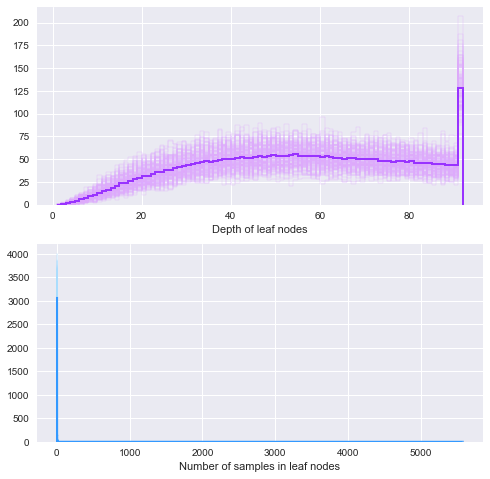

In [65]:
clf_new = clf.best_estimator_
draw_ensemble(clf_new)

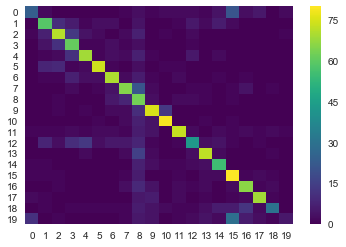

In [96]:
l = newsgroups_all.target_names
sns.heatmap(metrics.confusion_matrix(y_test, clf.predict(X_test)), cmap = 'viridis')

In [138]:
y1 = clf_new.feature_importances_

In [139]:
x1 = np.array(range(0, y1.shape[0]))

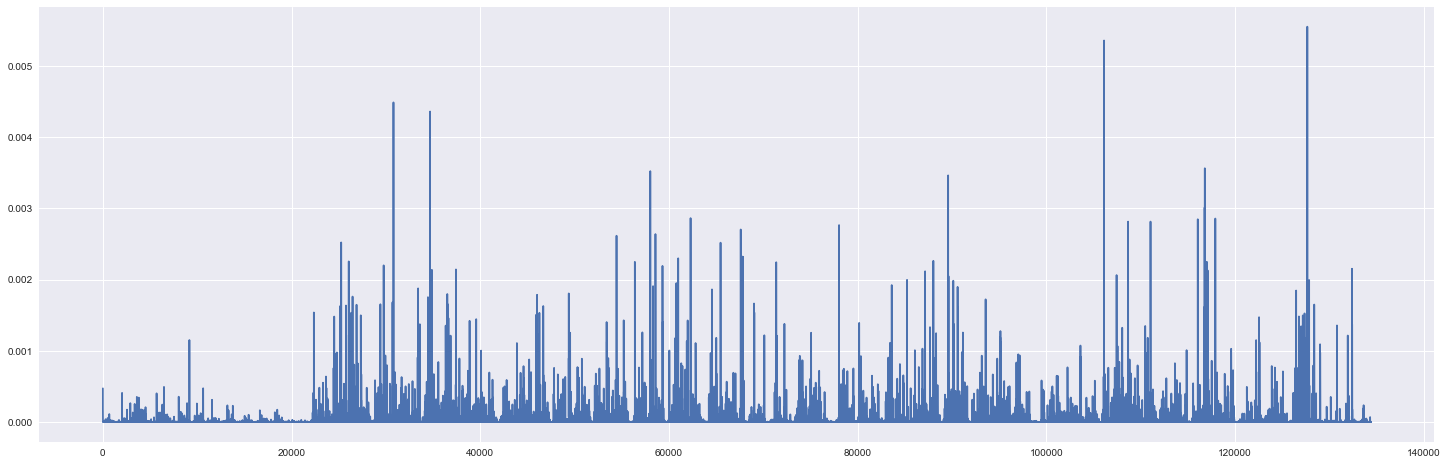

In [141]:
fig_size = [0, 0]
fig_size[0] = 25
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.plot(x1, y1);